In [149]:
library(tidyverse)
library(DESeq2)
library(BiocParallel)
library(pheatmap)

In [2]:
projects <- c("TCGA-CESC", "TCGA-OV", "TCGA-UCS", "TCGA-UCEC")
data_root <- "../../../../../mnt/d/TCGA"
count_files <- Sys.glob(paths = paste0(data_root, "/", "tumor_only_matrix_data", "/*counts.tsv"))
coldata_files <- Sys.glob(paths = paste0(data_root, "/", "tumor_only_matrix_data", "/*coldata.tsv"))

In [18]:
n_cores <- detectCores() - 2
BiocParallel::register(MulticoreParam(n_cores))

In [4]:
count_files
coldata_files

[1] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_CESC_counts.tsv"
[2] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_OV_counts.tsv"  
[3] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_UCEC_counts.tsv"
[4] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_UCS_counts.tsv"

[1] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_CESC_coldata.tsv"
[2] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_OV_coldata.tsv"  
[3] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_UCEC_coldata.tsv"
[4] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_UCS_coldata.tsv"

In [5]:
count_df_ls <- map(.x = count_files, .f = read_tsv)
coldata_df_ls <- map(.x = coldata_files, .f = read_tsv)

Parsed with column specification:
cols(
  .default = col_double(),
  hgnc_symbol = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  hgnc_symbol = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  hgnc_symbol = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  hgnc_symbol = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)
Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)
Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)
Parsed wit

In [73]:
data_sample_n <- function(count_df_ls, coldata_df_ls, n) {
    coldata_samp_ls <- list()
    count_samp_ls <- list()
    for (i in seq_len(length(count_df_ls))) {
        coldata_samp <- dplyr::sample_n(coldata_df_ls[[i]], size = n, replace = FALSE)
        count_samp <- dplyr::select(count_df_ls[[i]], hgnc_symbol, coldata_samp$sample_name)
        coldata_samp_ls[[i]] <- coldata_samp
        count_samp_ls[[i]] <- count_samp
    }
    coldata_samp_df <- bind_rows(coldata_samp_ls) %>%
        column_to_rownames(var = "sample_name")
    count_samp_df <- purrr::reduce(count_samp_ls, inner_join, by = "hgnc_symbol") %>%
        column_to_rownames(var = "hgnc_symbol")
    return(list(coldata_samp_df, count_samp_df))
}

## Take 10 random samples from each dataset

In [74]:
res_ls <- data_sample_n(count_df_ls, coldata_df_ls, 5)
coldata_samp_df <- res_ls[[1]]
count_samp_df <- res_ls[[2]]

In [75]:
all(rownames(coldata_samp_df) == colnames(count_samp_df))

[1] TRUE

In [76]:
coldata_samp_df$project

[1] "TCGA_CESC" "TCGA_CESC" "TCGA_CESC" "TCGA_CESC" "TCGA_CESC" "TCGA_OV"  
 [7] "TCGA_OV"   "TCGA_OV"   "TCGA_OV"   "TCGA_OV"   "TCGA_UCEC" "TCGA_UCEC"
[13] "TCGA_UCEC" "TCGA_UCEC" "TCGA_UCEC" "TCGA_UCS"  "TCGA_UCS"  "TCGA_UCS" 
[19] "TCGA_UCS"  "TCGA_UCS"

## Normalize counts using `rlog()`

In [78]:
rlog_count_samp <- rlog(as.matrix(count_samp_df))

converting counts to integer mode


In [116]:
rlog_count_samp_df <- rlog_count_samp %>%
    as_tibble() %>%
    mutate(hgnc_symbol = rownames(count_samp_df)) %>%
    select(hgnc_symbol, everything()) %>%
    column_to_rownames(var = "hgnc_symbol")

## Aggregate rows by within-project mean

In [117]:
CESC_mask <- coldata_samp_df$project == "TCGA_CESC"
OV_mask <- coldata_samp_df$project == "TCGA_OV"
UCEC_mask <- coldata_samp_df$project == "TCGA_UCEC"
UCS_mask <- coldata_samp_df$project == "TCGA_UCS"

In [118]:
rlog_count_agg_df <- rlog_count_samp_df %>%
    mutate(mean_CESC = rowMeans(dplyr::select(., which(CESC_mask)))) %>%
    mutate(mean_OV = rowMeans(dplyr::select(., which(OV_mask)))) %>%
    mutate(mean_UCEC = rowMeans(dplyr::select(., which(UCEC_mask)))) %>%
    mutate(mean_UCS = rowMeans(dplyr::select(., which(UCS_mask)))) %>%
    select(mean_CESC, mean_OV, mean_UCEC, mean_UCS)

In [119]:
head(rlog_count_agg_df)

,mean_CESC,mean_OV,mean_UCEC,mean_UCS
,<dbl>,<dbl>,<dbl>,<dbl>
1,3.2544877,3.6700086,2.964492,3.715651
2,5.3024749,5.4714873,5.245209,5.610004
3,0.1538972,0.3447544,0.650118,1.575474
4,12.7305342,13.5621442,13.479239,13.829891
5,4.8584171,6.6205873,5.435337,6.514780
6,9.5839517,6.5260827,6.729022,5.298601


## Look at 1000 genes with highest inter-project variance

In [120]:
inter_proj_vars <- rowVars(as.matrix(rlog_count_agg_df))

In [121]:
var_thresh <- inter_proj_vars[order(inter_proj_vars, decreasing = TRUE)][1000]

In [122]:
var_thresh

[1] 2.088411

In [123]:
ip_var_mask <- inter_proj_vars >= var_thresh

In [152]:
rlog_high_var_df <- rlog_count_samp_df %>%
    rownames_to_column("hgnc_symbol") %>%
    mutate(var_mask = ip_var_mask) %>%
    dplyr::filter(var_mask == TRUE) %>%
    select(-var_mask) %>%
    column_to_rownames(var = "hgnc_symbol")
head(rlog_high_var_df)

,TCGA-IR-A3LH-01A-21R-A213-07,TCGA-IR-A3LI-01A-11R-A32Y-07,TCGA-VS-A954-01A-11R-A38B-07,TCGA-EK-A2PI-01A-11R-A18M-07,TCGA-C5-A7CJ-01A-11R-A32P-07,TCGA-30-1857-01A-02R-1569-13,TCGA-25-1633-01A-01R-1566-13,TCGA-25-1627-01A-01R-1566-13,TCGA-13-0908-01B-01R-1565-13,TCGA-24-1435-01A-01R-1566-13,TCGA-BG-A0MO-01A-11R-A040-07,TCGA-AX-A2HJ-01A-11R-A17B-07,TCGA-B5-A11P-01B-11R-A14D-07,TCGA-FI-A2EY-01A-12R-A18M-07,TCGA-BG-A221-01A-21R-A157-07,TCGA-N5-A4R8-01A-11R-A28V-07,TCGA-ND-A4WF-01A-11R-A28V-07,TCGA-N9-A4Q7-01A-11R-A28V-07,TCGA-N5-A4RM-01A-11R-A28V-07,TCGA-N6-A4VE-01A-11R-A28V-07
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A2ML1,5.971969,10.538979,8.849176,9.984179,12.575456,6.178549,7.412005,7.588884,6.228214,5.222761,7.612894,7.692906,6.937488,4.874678,6.527144,5.221095,4.070988,4.139233,4.719890,8.341800
AARD,4.361842,3.278582,3.730858,5.181826,3.079529,10.180675,6.271875,4.915936,9.008829,5.944839,4.068790,4.006507,6.370399,3.588307,6.486721,6.815248,5.457797,5.069491,7.995360,6.495398
ABCA12,9.173478,9.818625,9.825593,8.456454,9.707591,4.735455,5.911295,5.699934,4.600981,5.027731,5.134733,4.975785,5.930604,7.223380,8.291650,4.379506,5.449294,5.431186,5.851211,6.763253
ACKR2,5.716683,10.463812,5.197449,5.041915,5.978584,9.836647,8.511851,6.615656,10.022807,9.502925,6.130476,6.338723,10.332587,8.366044,10.168563,5.706100,5.081070,4.703698,4.521736,7.386877
ACTC1,5.183820,3.409015,5.572817,4.275580,5.322120,4.669219,7.761102,3.051626,5.085436,5.131376,3.147929,5.885818,4.056416,5.144990,4.300676,13.222105,16.927066,3.322063,5.845741,6.616171
ACTN2,5.222350,2.706667,4.204691,4.944772,3.428219,3.359949,4.040402,4.532450,4.707614,3.943765,3.207847,4.279154,2.464658,4.119425,3.845699,11.139952,12.794072,7.111630,6.271997,6.300310


In [190]:
col_dist <- as.dist(1 - cor(rlog_high_var_df, method = "spearman"))
row_dist <- as.dist(1 - cor(t(rlog_high_var_df), method = "pearson"))

col_clust <- hclust(col_dist, method = "complete")
# row_clust <- cutree(hclust(row_dist, method = "complete"), k = 2)
row_clust <- hclust(row_dist, method = "complete")
# row_clust <- FALSE

In [191]:
cal_z_score <- function(x){
  (x - mean(x)) / sd(x)
}

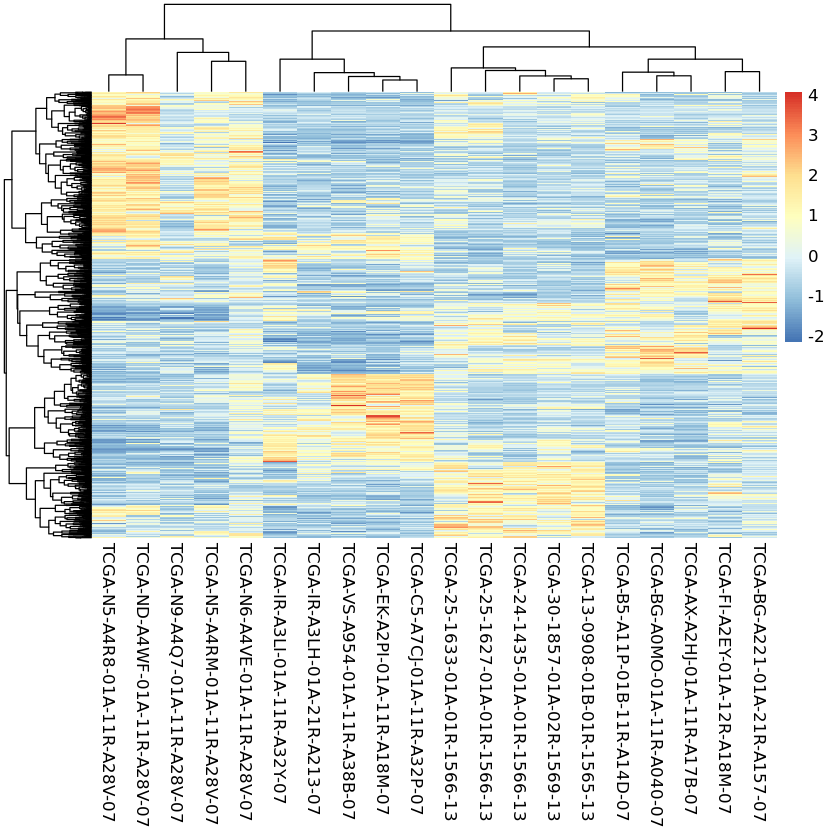

In [192]:
pheatmap(t(apply(rlog_high_var_df, 1, cal_z_score)), cluster_rows = row_clust, cluster_cols = col_clust, show_rownames = FALSE)